# 🧠 Práctica final NLP

## 📊 Análisis de Sentimiento - Etapa de entrenamiento y testeo de un modelo de análisis  de sentimiento

### 🛒 Dataset: Reviews de Amazon

Este dataset contiene reseñas de productos de Amazon clasificadas por categorías, en este caso, **Deportes y actividades al aire libre**.  
Cada reseña incluye una calificación representada por un **número de estrellas ⭐**.


# 1. Cargar el dataset proprocesado

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Cargar el dataset preprocesado
reviews_df = pd.read_csv('/content/preprocessed_dataset.csv')

# Verificar que el dataset se haya cargado correctamente
print("Dataset cargado exitosamente")
print(f"Dimensiones: {reviews_df.shape}")

Dataset cargado exitosamente
Dimensiones: (10000, 12)


In [ ]:
# Filtrar reviews para tener solo positivas y negativas (clasificación binaria)
binary_df = reviews_df[reviews_df['sentiment'] != 'neutral'].copy()

# Convertir sentimiento a variable binaria (1 para positivo, 0 para negativo)
binary_df['sentiment_binary'] = binary_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Verificar balance de clases
class_distribution = binary_df['sentiment_binary'].value_counts(normalize=True)
print("\nDistribución de clases:")
print(class_distribution)


Distribución de clases:
sentiment_binary
1    0.5
0    0.5
Name: proportion, dtype: float64


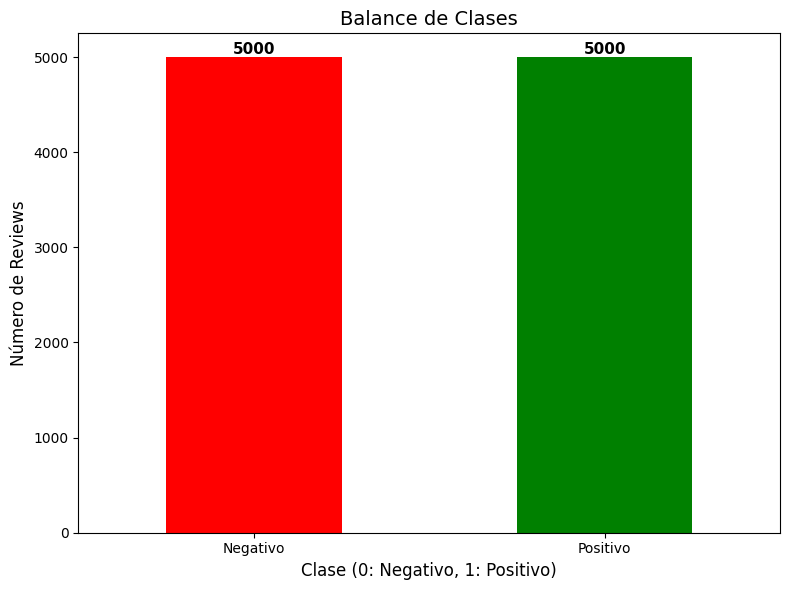

In [ ]:
# Visualizar balance de clases
plt.figure(figsize=(8, 6))
binary_df['sentiment_binary'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Balance de Clases', fontsize=14)
plt.xlabel('Clase (0: Negativo, 1: Positivo)', fontsize=12)
plt.ylabel('Número de Reviews', fontsize=12)
plt.xticks([0, 1], ['Negativo', 'Positivo'], rotation=0)

# Añadir valores sobre las barras
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height,
           f'{int(height)}',
           ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Dividir en conjuntos de entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    binary_df['processed_text_advanced'],  # Usando el texto preprocesado avanzado
    binary_df['sentiment_binary'],
    test_size=0.2,
    random_state=42,
    stratify=binary_df['sentiment_binary']  # Mantener la misma distribución de clases
)

print(f"\nConjunto de entrenamiento: {len(X_train)} muestras")
print(f"Conjunto de prueba: {len(X_test)} muestras")


Conjunto de entrenamiento: 8000 muestras
Conjunto de prueba: 2000 muestras


# 3. Vectorización

In [ ]:
# Vectorización 1: Bag-of-Words (Count Vectorizer)
print("\nVectorizando con CountVectorizer...")
count_vectorizer = CountVectorizer(
    max_features=5000,  # Limitamos a las 5000 palabras más frecuentes
    min_df=5,           # Ignorar términos que aparecen en menos de 5 documentos
    max_df=0.7,         # Ignorar términos que aparecen en más del 70% de documentos
    ngram_range=(1, 2)  # Incluir unigrams y bigrams
)

X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

print(f"Dimensión de la matriz Count: {X_train_counts.shape}")


Vectorizando con CountVectorizer...
Dimensión de la matriz Count: (8000, 5000)


In [ ]:
# Vectorización 2: TF-IDF
print("\nVectorizando con TfidfVectorizer...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Dimensión de la matriz TF-IDF: {X_train_tfidf.shape}")


Vectorizando con TfidfVectorizer...
Dimensión de la matriz TF-IDF: (8000, 5000)


# 4. Entrenamiento y evaluación de modelos

In [ ]:
# Función para entrenar y evaluar un modelo
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    print(f"\nEntrenando modelo: {model_name}")
    print("-" * 30)

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Predecir en conjunto de prueba
    y_pred = model.predict(X_test)

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nConfusion Matrix:")
    print(conf_matrix)
    print(f"\nClassification Report:")
    print(report)

    # Guardar predicciones de probabilidad
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = None

    return {
        'model': model,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': report,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [ ]:
# Entrenar Modelo 1: Naive Bayes con Count Vectorizer
model1_results = train_and_evaluate(
    MultinomialNB(alpha=1.0),
    X_train_counts,
    X_test_counts,
    y_train,
    y_test,
    "Naive Bayes con Count Vectorizer"
)


Entrenando modelo: Naive Bayes con Count Vectorizer
------------------------------
Accuracy: 0.8635

Confusion Matrix:
[[877 123]
 [150 850]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1000
           1       0.87      0.85      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [ ]:
# Entrenar Modelo 2: Regresión Logística con TF-IDF
model2_results = train_and_evaluate(
    LogisticRegression(max_iter=1000, C=1.0, random_state=42),
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test,
    "Regresión Logística con TF-IDF"
)


Entrenando modelo: Regresión Logística con TF-IDF
------------------------------
Accuracy: 0.8765

Confusion Matrix:
[[886 114]
 [133 867]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1000
           1       0.88      0.87      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



# 5. Comparar modelos

In [ ]:
print("\nComparación de modelos:")
print("="*30)
models_comparison = pd.DataFrame({
    'Modelo': ['Naive Bayes + Count', 'Regresión Logística + TF-IDF'],
    'Accuracy': [model1_results['accuracy'], model2_results['accuracy']]
})
print(models_comparison)


Comparación de modelos:
                         Modelo  Accuracy
0           Naive Bayes + Count    0.8635
1  Regresión Logística + TF-IDF    0.8765


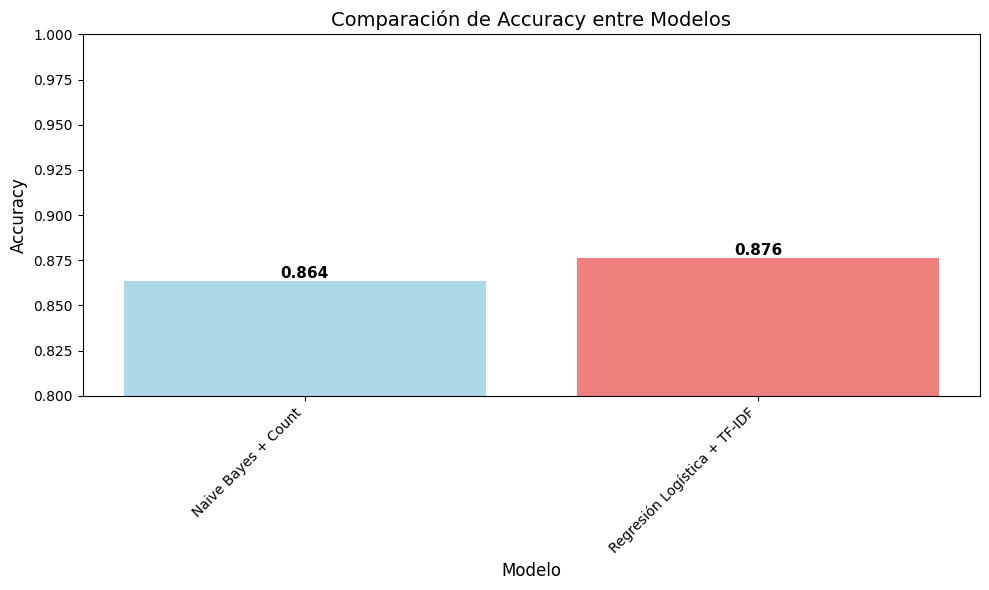

In [ ]:
# Visualizar comparación de modelos
plt.figure(figsize=(10, 6))
models = models_comparison['Modelo']
accuracies = models_comparison['Accuracy']
colors = ['lightblue', 'lightcoral']

bars = plt.bar(models, accuracies, color=colors)
plt.title('Comparación de Accuracy entre Modelos', fontsize=14)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45, ha='right')

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 6. Obtener el mejor modelo


El mejor modelo es: Regresión Logística con TF-IDF
Accuracy: 0.8765


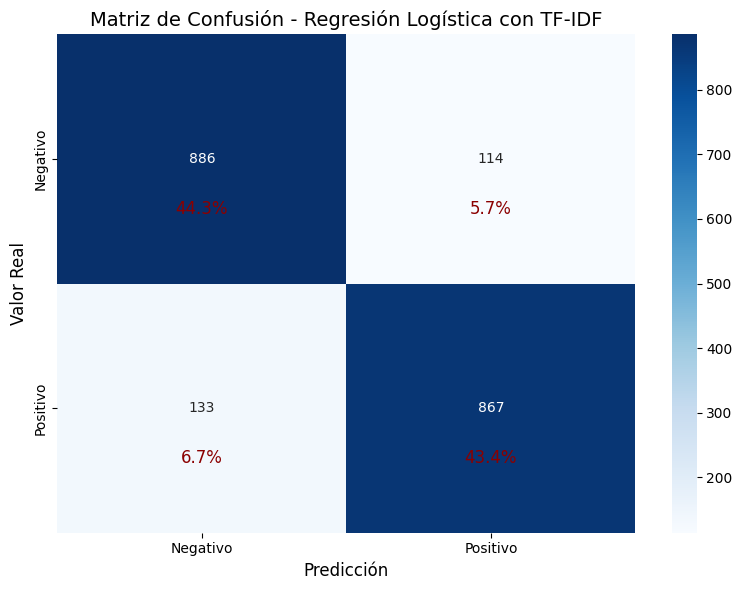

In [ ]:
# Elegir el mejor modelo
best_model_idx = 1 if model1_results['accuracy'] > model2_results['accuracy'] else 2
best_model_results = model1_results if best_model_idx == 1 else model2_results
best_model_name = "Naive Bayes con Count Vectorizer" if best_model_idx == 1 else "Regresión Logística con TF-IDF"

print(f"\nEl mejor modelo es: {best_model_name}")
print(f"Accuracy: {best_model_results['accuracy']:.4f}")

# Visualizar matriz de confusión del mejor modelo
plt.figure(figsize=(8, 6))
conf_matrix = best_model_results['confusion_matrix']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.title(f'Matriz de Confusión - {best_model_name}', fontsize=14)

# Añadir porcentajes
total = sum(sum(conf_matrix))
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        percentage = conf_matrix[i][j] / total * 100
        plt.text(j + 0.5, i + 0.7, f'{percentage:.1f}%',
                ha='center', va='center', fontsize=12, color='darkred')

plt.tight_layout()
plt.show()

In [ ]:
# Guardar el mejor modelo y vectorizador
import pickle

with open('/content/best_model.pkl', 'wb') as f:
    pickle.dump(best_model_results['model'], f)

best_vectorizer = count_vectorizer if best_model_idx == 1 else tfidf_vectorizer
with open('/content/best_vectorizer.pkl', 'wb') as f:
    pickle.dump(best_vectorizer, f)

print("\nModelo y vectorizador guardados en archivos .pkl")


Modelo y vectorizador guardados en archivos .pkl


In [ ]:
# Guardar resultados de entrenamiento
results_summary = {
    'mejor_modelo': best_model_name,
    'accuracy': best_model_results['accuracy'],
    'confusion_matrix': best_model_results['confusion_matrix'].tolist(),
    'vectorizacion': 'Count' if best_model_idx == 1 else 'TF-IDF'
}

with open('/content/training_results.json', 'w') as f:
    import json
    json.dump(results_summary, f, indent=4)

# Descargar archivos generados
from google.colab import files
files.download('/content/best_model.pkl')
files.download('/content/best_vectorizer.pkl')
files.download('/content/training_results.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>